In [96]:
# Import libraries
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# Download the 311 complaints about syringes
syringe_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?descriptor=Syringes&$limit=50000')
syringe_complaints.head(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,64383740,2025-03-17T20:52:18.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Gutter,11105.0,41-20 21 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.774014,-73.902893,"\n, \n(40.77401435876592, -73.90289303834986)"
1,64382203,2025-03-17T17:51:46.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,11238.0,10 GREENE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.685934,-73.972478,"\n, \n(40.68593436748149, -73.97247775801303)"


In [5]:
# Look at the data types
syringe_complaints.dtypes

,0
unique_key,int64
created_date,object
closed_date,object
agency,object
agency_name,object
complaint_type,object
descriptor,object
location_type,object
incident_zip,float64
incident_address,object


In [6]:
# Convert created_date from an object to a date
syringe_complaints['created_date'] = pd.to_datetime(syringe_complaints['created_date'])

In [7]:
# Extract month and year from created_date
syringe_complaints['month'] = syringe_complaints['created_date'].dt.month
syringe_complaints['year'] = syringe_complaints['created_date'].dt.year

In [27]:
# Look for missing values
syringe_complaints.isna().sum()

,0
unique_key,0
created_date,0
closed_date,15
agency,0
agency_name,0
complaint_type,0
descriptor,0
location_type,0
incident_zip,1
incident_address,1


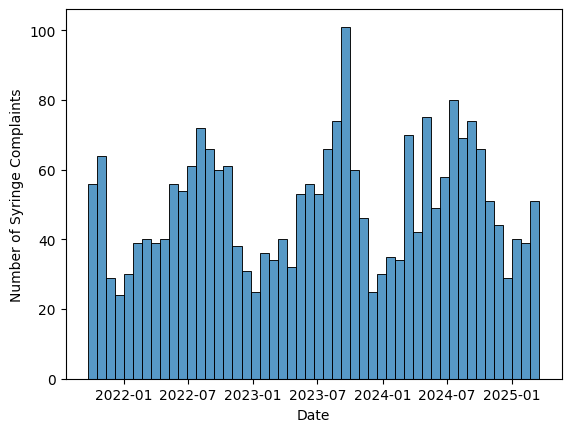

In [44]:
# Make a plot to show the frequency of syringe complaints
ax = sns.histplot(data=syringe_complaints['created_date'], bins = 50)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Syringe Complaints')
plt.show()

Interesting finding: syringe complaints appear to peak at similar times each year!

complaint_count
year month                 
2021 9                   27
     10                  80
     11                  31
     12                  34
2022 1                   34
     2                   48
     3                   48
     4                   46
     5                   61
     6                   65
     7                   71
     8                   98
     9                   69
     10                  78
     11                  41
     12                  35
2023 1                   36
     2                   41
     3                   49
     4                   35
     5                   65
     6                   59
     7                   81
     8                   94
     9                  104
     10                  68
     11                  47
     12                  27
2024 1                   49
     2                   39
     3                   77
     4                   62
     5                   72
     6                   73
     7                   90
     8                   82
     9                   88
     10                  75
     11                  54
     12                  34
2025 1                   49
     2                   45
     3                   36

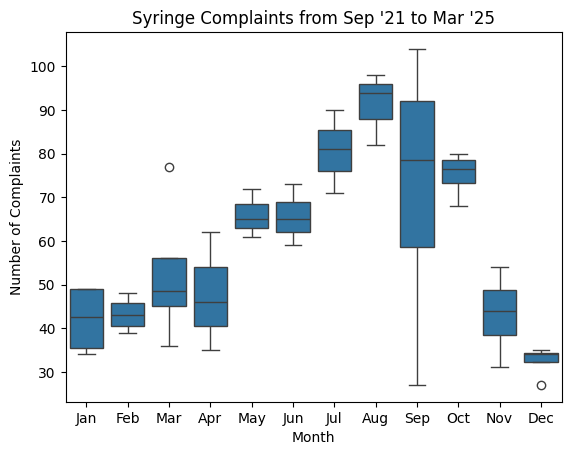

In [113]:
# Make a boxplot to show the number of syringe complaints each month
ax = sns.boxplot(data = syringe_complaints.groupby(['year', 'month'])['created_date'].agg(complaint_count = 'count').reset_index(),
                 x = 'month',
                 y = 'complaint_count')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Complaints')
plt.title('Syringe Complaints from Sep \'21 to Mar \'25')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

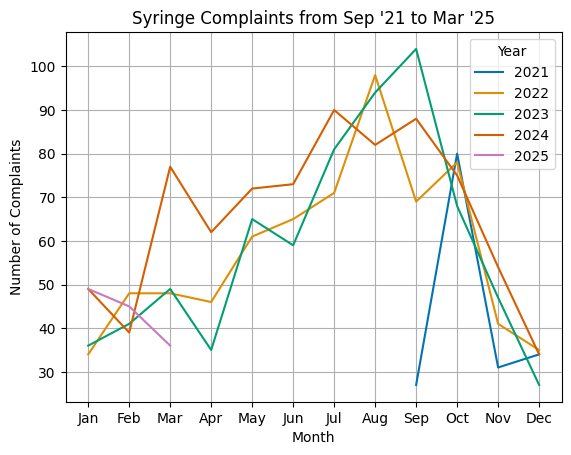

In [115]:
# Make a lineplot of the number of syringe complaints each month, with a different line pear year
ax = sns.lineplot(data = syringe_complaints.groupby(['year', 'month'])['created_date'].agg(complaint_count = 'count').reset_index(),
                  x = 'month',
                  y = 'complaint_count',
                  hue = 'year',
                  palette = 'colorblind')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Syringe Complaints from Sep \'21 to Mar \'25')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

Much more analysis TBD...

In [116]:
# Download the sharps dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)
